In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import folium
from folium import plugins

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.linear_model import Lasso

import warnings

warnings.filterwarnings(action = 'ignore')
plt.rc("font",family="Malgun Gothic")
plt.rc("axes",unicode_minus=False)
pd.set_option('display.max_columns', None)

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df2 = pd.read_csv('2.광양시_재활용품분리수거_장려금지급내역(수정수정삭제).csv')
df3 = pd.read_csv('3.광양시_금호동_집적장별_재할용품통계(수정).csv', encoding = 'euc-kr')
df4 = pd.read_csv('4.광양시_건축물_표제부(수정수정수정수정).csv', encoding = 'euc-kr')

df15 = gpd.read_file('15.광양시_건물정보.geojson')
df11 = pd.read_csv('11.광양시_동별인구수_세대수.csv')

# 목차

## 1. 전처리

    1.1 df2 ('2.광양시_재활용품분리수거_장려금지급내역.csv')
        1.1.1 kg단위로 환산
        1.1.2 Column 주요배출항목 / 기타배출항목으로 단일화

    1.2 df3 ('3.광양시_금호동_집적장별_재할용품통계.csv')
        - kg단위로 통일

    1.3 df4 ('4.광양시_건축물_표제부.csv')
        - Columns 정리 
        - 건물명별로 household_cnt 집계
        
    1.4 df11 ('11.광양시_동별인구수_세대수.csv')
        - Columns 정리
        
    1.5 외부데이터 df15 ('15.광양시_건물정보.geojson')
    
## 2. 데이터 종합


## 3. Feature Engineering
    3.1 추정거주인구 보간
    3.2 최종데이터 종합
    3.3 주요배출항목(A_recycle) 보간
    3.4 기타배출항목(B_recycle) 보간
    3.5 총 장려금교부액(subsidy) 보간

## 4. 클러스터링
    4.1 필요 Module
    4.2 시각화
    4.3 최적 k값 찾기

## 5. 수거기 최적 위치 선정
    5.1 각 Feature별 가중치 값 찾기
    5.2 구간별 점수화
    5.3 결과
    
## 6. 금호동
    6.1 주요배출항목(A_recycle) 보간
    6.2 기타배출항목(B_recycle) 보간
    6.3 총 장려금교부액(subsidy) 보간
    6.4 각 Feature 가중치 값 산정 및 구간화
    6.5 결과

## 1. 전처리

### 1.1 df2 ('2.광양시_재활용품분리수거_장려금지급내역.csv')

#### 1.1.1 kg단위로 환산 
    - 유리병(kg당 70원), 페트병(kg당 40원), 플라스틱류(kg당 30원), 폐형광등(kg당 150원), 필름류포장재비닐(kg당 200원), 폐건전지류(kg당 600원), 종이팩(kg당 200원), 소형가전(kg당 300원), 휴대폰(kg당 1000원)
#### 1.1.2 Column 주요배출항목 / 기타배출항목으로 단일화
    - 주요배출항목('A_recycle') : glass, pet, plastic
    - 기타배출항목('B_recycle') : vinyl, battery, carton, smallappliance, hp

In [3]:
df2_sum = pd.DataFrame(df2.groupby(['emd_nm', 'complex_nm'])['glass', 'pet', 'plastic', 'lamp', 'vinyl', 'battery', 'carton', 'smallappliance', 'hp', 'subsidy'].sum()).reset_index()

df2_sum['glass/kg'] = (df2_sum['glass'] / 70)
df2_sum['pet/kg'] = (df2_sum['pet'] / 40)
df2_sum['plastic/kg'] = (df2_sum['plastic'] / 30)
df2_sum['lamp/kg'] = (df2_sum['lamp'] / 150)
df2_sum['vinyl/kg'] = (df2_sum['vinyl'] / 200)
df2_sum['battery/kg'] = (df2_sum['battery'] / 600)
df2_sum['carton/kg'] = (df2_sum['carton'] / 200)
df2_sum['smallappliance/kg'] = (df2_sum['smallappliance'] / 300)
df2_sum['hp/kg'] = (df2_sum['hp'] / 1000)

df2_sum = df2_sum[['emd_nm', 'complex_nm', 'glass', 'glass/kg', 'pet', 'pet/kg', 'plastic', 'plastic/kg', 'lamp', 'lamp/kg',
                   'vinyl', 'vinyl/kg', 'battery', 'battery/kg', 'carton', 'carton/kg', 'smallappliance', 'smallappliance/kg', 
                   'hp', 'hp/kg', 'subsidy']]
df2_sum = df2_sum.rename(columns = {'complex_nm' : 'bldg_nm'})


In [4]:
df2_sum['A_recycle'] = df2_sum['glass/kg'] + df2_sum['pet/kg'] + df2_sum['plastic/kg']
df2_sum['B_recycle'] = df2_sum['vinyl/kg'] + df2_sum['battery/kg'] + df2_sum['carton/kg'] + df2_sum['smallappliance/kg'] + df2_sum['hp/kg'] + df2_sum['lamp/kg']
df2_sum = df2_sum[['emd_nm', 'bldg_nm', 'A_recycle', 'B_recycle', 'subsidy']]

### 1.2 df3 ('3.광양시_금호동_집적장별_재할용품통계.csv')
    - paper는 최초 ton단위로 집계되었으므로 kg단위로 통일

In [5]:
df3['paper'] = (df3['paper'] * 1000)

### 1.3 df4 ('4.광양시_건축물_표제부.csv')
    - Columns 정리 
    - 건물명별로 household_cnt 집계

In [6]:
df4 = df4[['bldg_nm', 'land_location', 'bun', 'ji', 'main_annex_gbn', 'purpose_nm', 'etc_purpose_nm', 'household_cnt', 'lon', 'lat']]

df4.dropna(inplace = True)

df4_sum = pd.DataFrame(df4.groupby('bldg_nm')['household_cnt'].sum()).reset_index()

new_df4 = df4.drop_duplicates(['bldg_nm']).reset_index()
new_df4.drop(['index'], axis = 1, inplace = True)

final = new_df4.merge(df4_sum, on = 'bldg_nm', how = 'left')
final.drop(['household_cnt_x'], axis = 1, inplace = True)
final = final.rename(columns = {'household_cnt_y' : 'household_cnt'})

### 1.4. df11 ('11.광양시_동별인구수_세대수.csv')
    - Columns 정리

In [7]:
df11 = df11[['emd_nm', 'hh_pop_cnt_2020']]

### 1.5 외부데이터 df15 ('15.광양시_건물정보.geojson')
    - "(광양시) 전기자동차 충전소 최적입지 선정" 과제에서 데이터 가져옴.
    - 법정동을 행정동으로 변경
    - df11을 활용해 동별인구추산

In [8]:
df15['법정동명'] = df15['법정동명'].str[0:12]
df15 = df15[(df15.세부용도명 == '다가구주택') | (df15.세부용도명 == '단독주택') | (df15.세부용도명 == '아파트')| (df15.세부용도명 == '연립주택')| (df15.세부용도명 == '다세대주택')| (df15.세부용도명 == '공관')| (df15.세부용도명 == '기숙사')]
df15 = df15[['법정동코드', '법정동명', '지번', '건물명', '건물동명', '건물연면적', '주요용도명', '세부용도명', 'geometry']]
df15 = df15[df15['주요용도명'] != '제2종근린생활시설']
df15.reset_index(inplace = True)
df15.drop(['index'], axis = 1, inplace = True)

# 법정동을 행정동으로 변경

golyak_list = ['전라남도 광양시 도이동', '전라남도 광양시 성황동', '전라남도 광양시 중군동', '전라남도 광양시 황금동', '전라남도 광양시 황길동']
jungma_list = ['전라남도 광양시 중동','전라남도 광양시 마동']

for i in range(len(df15)):
    if df15['법정동명'][i] in golyak_list :
        df15['법정동명'][i] = '전라남도 광양시 골약동'
        
for i in range(len(df15)):
    if df15['법정동명'][i] in jungma_list :
        df15['법정동명'][i] = '전라남도 광양시 중마동'
        
# 읍/면별로 필터
광양읍 = df15[(df15.법정동명 == '전라남도 광양시 광양읍')]
봉강면 = df15[(df15.법정동명 == '전라남도 광양시 봉강면')]
옥룡면 = df15[(df15.법정동명 == '전라남도 광양시 옥룡면')]
옥곡면 = df15[(df15.법정동명 == '전라남도 광양시 옥곡면')]
진상면 = df15[(df15.법정동명 == '전라남도 광양시 진상면')]
진월면 = df15[(df15.법정동명 == '전라남도 광양시 진월면')]
다압면 = df15[(df15.법정동명 == '전라남도 광양시 다압면')]
중마동 = df15[(df15.법정동명 == '전라남도 광양시 중마동')]
골약동 = df15[(df15.법정동명 == '전라남도 광양시 골약동')]
광영동 = df15[(df15.법정동명 == '전라남도 광양시 광영동')]
금호동 = df15[(df15.법정동명 == '전라남도 광양시 금호동')]
태인동 = df15[(df15.법정동명 == '전라남도 광양시 태인동')]


# 읍/면별로 주택연면적 산출
광양읍주택연면적 = 광양읍['건물연면적'].sum()
봉강면주택연면적 = 봉강면['건물연면적'].sum()
옥룡면주택연면적 = 옥룡면['건물연면적'].sum()
옥곡면주택연면적 = 옥곡면['건물연면적'].sum()
진상면주택연면적 = 진상면['건물연면적'].sum()
진월면주택연면적 = 진월면['건물연면적'].sum()
다압면주택연면적 = 다압면['건물연면적'].sum()
골약동주택연면적 = 골약동['건물연면적'].sum()
중마동주택연면적 = 중마동['건물연면적'].sum()
광영동주택연면적 = 광영동['건물연면적'].sum()
금호동주택연면적 = 금호동['건물연면적'].sum()
태인동주택연면적 = 태인동['건물연면적'].sum()

# 인구
광양읍인구 = df11.iloc[0, 1]
봉강면인구 = df11.iloc[1, 1]
옥룡면인구 = df11.iloc[2, 1]
옥곡면인구 = df11.iloc[3, 1]
진상면인구 = df11.iloc[4, 1]
진월면인구 = df11.iloc[5, 1]
다압면인구 = df11.iloc[6, 1]
골약동인구 = df11.iloc[7, 1]
중마동인구 = df11.iloc[8, 1]
광영동인구 = df11.iloc[9, 1]
금호동인구 = df11.iloc[10, 1]
태인동인구 = df11.iloc[11, 1]


# 행정동별 1인당 주거면적
광양읍인당주거면적 = 광양읍주택연면적 / 광양읍인구
봉강면인당주거면적 = 봉강면주택연면적 / 봉강면인구
옥룡면인당주거면적 = 옥룡면주택연면적 / 옥룡면인구
옥곡면인당주거면적 = 옥곡면주택연면적 / 옥곡면인구
진상면인당주거면적 = 진상면주택연면적 / 진상면인구
진월면인당주거면적 = 진월면주택연면적 / 진월면인구
다압면인당주거면적 = 다압면주택연면적 / 다압면인구
골약동인당주거면적 = 골약동주택연면적 / 골약동인구
중마동인당주거면적 = 중마동주택연면적 / 중마동인구
광영동인당주거면적 = 광영동주택연면적 / 광영동인구
금호동인당주거면적 = 금호동주택연면적 / 금호동인구
태인동인당주거면적 = 태인동주택연면적 / 태인동인구

# 광양읍 주거용도건물 인구추산
광양읍['추정거주인구'] = 광양읍['건물연면적']/광양읍인당주거면적
봉강면['추정거주인구'] = 봉강면['건물연면적']/봉강면인당주거면적
옥룡면['추정거주인구'] = 옥룡면['건물연면적']/옥룡면인당주거면적
옥곡면['추정거주인구'] = 옥곡면['건물연면적']/옥곡면인당주거면적
진상면['추정거주인구'] = 진상면['건물연면적']/진상면인당주거면적
진월면['추정거주인구'] = 진월면['건물연면적']/진월면인당주거면적
다압면['추정거주인구'] = 다압면['건물연면적']/다압면인당주거면적
골약동['추정거주인구'] = 골약동['건물연면적']/골약동인당주거면적
중마동['추정거주인구'] = 중마동['건물연면적']/중마동인당주거면적
광영동['추정거주인구'] = 광영동['건물연면적']/광영동인당주거면적
금호동['추정거주인구'] = 금호동['건물연면적']/금호동인당주거면적
태인동['추정거주인구'] = 태인동['건물연면적']/태인동인당주거면적



merge_df15 = pd.concat([광양읍, 봉강면, 옥룡면, 옥곡면, 진상면, 진월면, 다압면, 골약동, 중마동, 
                       광영동, 금호동, 태인동])
merge_df15 = merge_df15.reset_index()
merge_df15.drop('index', axis = 1, inplace = True)

df_15 = merge_df15[(merge_df15.주요용도명 == '공동주택')]
df_15 = pd.DataFrame(df_15.groupby('건물명')['추정거주인구'].sum()).reset_index()

new = merge_df15.merge(df_15, on = '건물명', how = 'right')
new = new.drop_duplicates(['건물명'])
new = new.rename(columns = {'추정거주인구_y' : '추정거주인구'})


## 2. 데이터 종합

In [9]:
# '장미아파트' -> '장미연립아파트'로 명칭 변경
final.loc[final.bldg_nm == '장미아파트', ('bldg_nm')] = '장미연립아파트'
tmp = final[(final.bldg_nm != '장미연립아파트') & (final.bldg_nm != '장미아파트')]
target = final[final.bldg_nm == '장미연립아파트'][['bldg_nm', 'land_location', 'bun','ji','main_annex_gbn','purpose_nm','etc_purpose_nm', 'lon', 'lat']]
target['household_cnt'] = 661+172
tartget = target[0:1]
final = pd.concat([tmp, target[0:1]])
final.reset_index(inplace = True)
final.loc[final.bldg_nm == '장미연립아파트']

new = new.rename(columns = {'건물명' : 'bldg_nm'})

# 최종 4번 데이터 + 최종 15번 데이터
final1 = final.merge(new, on = 'bldg_nm', how = 'left')

## 3. Feature Engineering

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.linear_model import LogisticRegression

### 3.1 추정거주인구 보간

In [11]:
final1 = final1[['bldg_nm', 'land_location', 'bun', 'ji', 'main_annex_gbn', 'purpose_nm', 'etc_purpose_nm', 'lon', 'lat', 'household_cnt', 
                'geometry', '법정동명']]
final1['land_location'] = final1['land_location'].str[0:12]

golyak_list = ['전라남도 광양시 도이동', '전라남도 광양시 성황동', '전라남도 광양시 중군동', '전라남도 광양시 황금동', '전라남도 광양시 황길동']
jungma_list = ['전라남도 광양시 중동 ','전라남도 광양시 마동 ']

for i in range(len(final1)):
    if final1['land_location'][i] in golyak_list :
        final1['land_location'][i] = '전라남도 광양시 골약동'
        
for i in range(len(final1)):
    if final1['land_location'][i] in jungma_list :
        final1['land_location'][i] = '전라남도 광양시 중마동'

        
final1['추정거주인구'] = None

광양읍세대당인구 = df11.iloc[0, 1]
옥곡면세대당인구 = df11.iloc[3, 1]
다압면세대당인구 = df11.iloc[6, 1]
중마동세대당인구 = df11.iloc[8, 1]
광영동세대당인구 = df11.iloc[9, 1]
금호동세대당인구 = df11.iloc[10, 1]
태인동세대당인구 = df11.iloc[11, 1]


for i in range(len(final1)):
    if final1.land_location[i] == '전라남도 광양시 광양읍':
        final1.추정거주인구[i] = (final1.household_cnt[i] * 광양읍세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 옥곡면':
        final1.추정거주인구[i] = (final.household_cnt[i] * 옥곡면세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 다압면':
        final1.추정거주인구[i] = (final.household_cnt[i] * 다압면세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 중마동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 중마동세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 광영동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 광영동세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 금호동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 금호동세대당인구)
    elif final1.land_location[i] == '전라남도 광양시 태인동':
        final1.추정거주인구[i] = (final.household_cnt[i] * 태인동세대당인구)

        

### 3.2 데이터 종합

In [12]:
final1 = final1.merge(df2_sum, on = 'bldg_nm', how = 'left')

final1 = final1.drop(['emd_nm', '법정동명'], axis = 1)

final1 = final1.astype({'추정거주인구' : 'float64'})
final1 = final1.reset_index()
final1 = final1.drop('index', axis = 1)

### 3.3 주요배출항목(A_recycle) 보간

In [13]:
# 금호동 데이터셋 
final1_geumho = final1[(final1.land_location == '전라남도 광양시 금호동')]
# 금호동 제외
final1 = final1[(final1.land_location != '전라남도 광양시 금호동')]

# train / test set 분리
train = final1.loc[final1['subsidy'].notnull()]
test = final1.loc[final1['subsidy'].isna()]


X_train = train[['land_location', 'household_cnt', '추정거주인구']]
X_train = pd.get_dummies(X_train)
X_test = test[['land_location', 'household_cnt', '추정거주인구']]
X_test = pd.get_dummies(X_test)

y_train = train['A_recycle']
y_test = test['A_recycle']

model_ridge = Ridge(solver = 'svd', alpha = 1).fit(X_train, y_train)

ridge_pred_A_recycle = model_ridge.predict(X_test)


In [14]:
ridge_pred_A_recycle

array([11502.26744037, 11502.26744037,  5801.87748945, 11493.29309963,
       11475.34441817, 11448.42139597,  5769.875099  , 11430.4727145 ,
       11430.4727145 , 11430.4727145 ,  7521.78589631, 11421.49837377,
       11529.19046256, 11394.57535157, 11484.3187589 , 11457.3957367 ,
       11376.6266701 , 11358.67798864, 11358.67798864, 11358.67798864,
       11430.4727145 , 11430.4727145 , 11358.67798864, 11358.67798864,
       11358.67798864, 11358.67798864, 11430.4727145 , 11358.67798864,
       11358.67798864, 11358.67798864,  7424.38584434, 11403.5496923 ,
        7434.12584954,  5719.58562828,  5719.58562828,  5719.58562828,
        7414.64583915, 11412.52403303, 11394.57535157, 11340.72930717,
        7424.38584434,  7453.60585994,  7434.12584954,  7628.92595348,
       -4020.11495279,  5724.15739834,  5710.44208815,  8028.26616656,
       11457.3957367 , 11457.3957367 , 11457.3957367 ,  7560.7459171 ,
       11439.44705523, 11430.4727145 , 11430.4727145 , 11430.4727145 ,
      

### 3.4 기타배출항목(B_recycle) 보간

In [15]:
train = final1.loc[final1['subsidy'].notnull()]
test = final1.loc[final1['subsidy'].isna()]


X_train = train[['land_location', 'household_cnt', '추정거주인구']]
X_train = pd.get_dummies(X_train)
X_test = test[['land_location', 'household_cnt', '추정거주인구']]
X_test = pd.get_dummies(X_test)

y_train = train['B_recycle']
y_test = test['B_recycle']

model_ridge = Ridge(solver = 'svd', alpha = .1).fit(X_train, y_train)

ridge_pred_B_recycle = model_ridge.predict(X_test)

In [16]:
ridge_pred_B_recycle

array([ 1600.02591904,  1600.02591904,  1215.3065539 ,  1598.27013766,
        1594.7585749 ,  1589.49123076,  1207.97354134,  1585.979668  ,
        1585.979668  ,  1585.979668  ,   882.86777045,  1584.22388662,
        1605.29326318,  1578.95654248,  1596.51435628,  1591.24701214,
        1575.44497973,  1571.93341697,  1571.93341697,  1571.93341697,
        1585.979668  ,  1585.979668  ,  1571.93341697,  1571.93341697,
        1571.93341697,  1571.93341697,  1585.979668  ,  1571.93341697,
        1571.93341697,  1571.93341697,   864.0782903 ,  1580.71232386,
         865.95723831,  1196.4502359 ,  1196.4502359 ,  1196.4502359 ,
         862.19934228,  1582.46810524,  1578.95654248,  1568.42185421,
         864.0782903 ,   869.71513434,   865.95723831,   903.53619862,
       -2512.6990046 ,  1197.49780912,  1194.35508946,   980.57306726,
        1591.24701214,  1591.24701214,  1591.24701214,   890.38356252,
        1587.73544938,  1585.979668  ,  1585.979668  ,  1585.979668  ,
      

### 3.5 총 장려금교부액(subsidy) 보간

In [17]:
train = final1.loc[final1['subsidy'].notnull()]
test = final1.loc[final1['subsidy'].isna()]


X_train = train[['land_location', 'household_cnt', '추정거주인구']]
X_train = pd.get_dummies(X_train)

X_test = test[['land_location', 'household_cnt', '추정거주인구']]
X_test = pd.get_dummies(X_test)

y_train = train['subsidy']
y_test = test['subsidy']

model_ridge = Ridge(solver = 'svd', alpha = .1).fit(X_train, y_train)

ridge_pred_subsidy = model_ridge.predict(X_test)


In [18]:
ridge_pred_subsidy

array([  679207.67634986,   679207.67634986,   254608.82119363,
         678219.7862897 ,   676244.00616939,   673280.33598892,
         252350.47797931,   671304.5558686 ,   671304.5558686 ,
         671304.5558686 ,   376024.75798993,   670316.66580845,
         682171.34653032,   667352.99562798,   677231.89622954,
         674268.22604907,   665377.21550766,   663401.43538735,
         663401.43538735,   663401.43538735,   671304.5558686 ,
         671304.5558686 ,   663401.43538735,   663401.43538735,
         663401.43538735,   663401.43538735,   671304.5558686 ,
         663401.43538735,   663401.43538735,   663401.43538735,
         364988.86677798,   668340.88568813,   366092.45589918,
         248801.65292823,   248801.65292823,   248801.65292823,
         363885.27765679,   669328.77574829,   667352.99562798,
         661425.65526704,   364988.86677798,   368299.63414157,
         366092.45589918,   388164.23832307, -1840453.82031629,
         249124.27338742,   248156.41200

In [19]:
# 모델링에 필요한 데이터 
test['ridge_pred_subsidy'] = ridge_pred_subsidy
test['ridge_pred_A_recycle'] = ridge_pred_A_recycle
test['ridge_pred_B_recycle'] = ridge_pred_B_recycle

test = test.drop(['A_recycle', 'B_recycle', 'subsidy'], axis = 1)

test = test.rename(columns = {'ridge_pred_B_recycle': 'B_recycle'})
test = test.rename(columns = {'ridge_pred_A_recycle' : 'A_recycle'})
test = test.rename(columns = {'ridge_pred_subsidy' : 'subsidy'})

final_final = pd.concat([train, test])
final_final

,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,geometry,추정거주인구,A_recycle,B_recycle,subsidy
89,성호2차아파트,전라남도 광양시 중마동,"""1665""","""0000""",주건축물,공동주택,아파트,127.690977,34.932170,4073,"MULTIPOLYGON (((127.69093 34.93353, 127.69031 ...",10304.69,30000.000000,5840.000000,2.335540e+06
90,광영상아아파트,전라남도 광양시 광영동,"""0757""","""0001""",주건축물,공동주택,아파트,127.718082,34.966717,655,None,1480.30,9561.000000,3532.000000,1.019790e+06
91,중마부영2차아파트,전라남도 광양시 중마동,"""1354""","""0000""",주건축물,공동주택,아파트,127.693434,34.942507,1466,None,3708.98,10443.000000,3250.000000,9.642500e+05
92,대림아파트,전라남도 광양시 광양읍,"""1755""","""0001""",주건축물,공동주택,아파트,127.565044,34.969006,917,"MULTIPOLYGON (((127.56460 34.96943, 127.56535 ...",2109.10,13800.000000,7387.000000,1.912450e+06
93,대광로제비앙2차아파트,전라남도 광양시 중마동,"""1592""","""0000""",주건축물,공동주택,아파트,127.688735,34.951843,392,None,991.76,16026.000000,1696.000000,1.040500e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,시엘2차,전라남도 광양시 광양읍,"""0562""","""0000""",주건축물,공동주택,아파트,127.590375,34.981895,16,"MULTIPOLYGON (((127.59039 34.98213, 127.59048 ...",36.80,11430.472715,1585.979668,6.713046e+05
190,자연애6차,전라남도 광양시 광양읍,"""0809""","""0010""",주건축물,공동주택,아파트,127.576998,34.978288,8,None,18.40,11358.677989,1571.933417,6.634014e+05
191,노블레스시티,전라남도 광양시 중마동,"""1316""","""0005""",주건축물,공동주택,오피스텔,127.697007,34.941416,59,None,149.27,5961.889442,1251.971617,2.659005e+05
192,광양스카이뷰,전라남도 광양시 광양읍,"""0847""","""0000""",주건축물,공동주택,오피스텔,127.568414,34.967404,52,"MULTIPOLYGON (((127.56879 34.96744, 127.56875 ...",119.60,11753.548981,1649.187798,7.068686e+05


## 4. 클러스터링

### 4.1 필요 Module

In [20]:
from sklearn.cluster import KMeans
from sklearn import cluster
import folium

from shapely.geometry import Point, Polygon, LineString

### 4.2 최적 k값 찾기

In [21]:
# 클러스터링 전 마이너스값 대체
final_final.loc[44, 'B_recycle'] = 168.812292
final_final.loc[44, 'A_recycle'] = 11394.770791
final_final.loc[44, 'subsidy'] = 670965

In [22]:
cluster_features = final_final[['household_cnt', '추정거주인구', 'subsidy', 'A_recycle', 'B_recycle']]

In [23]:
final_cluster = final_final

kmeans = cluster.KMeans(n_clusters=5, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_5'] = cluster_label

kmeans = cluster.KMeans(n_clusters=6, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_6'] = cluster_label

kmeans = cluster.KMeans(n_clusters=7, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_7'] = cluster_label

kmeans = cluster.KMeans(n_clusters=8, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_8'] = cluster_label

kmeans = cluster.KMeans(n_clusters=9, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_9'] = cluster_label

kmeans = cluster.KMeans(n_clusters=10, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_10'] = cluster_label

kmeans = cluster.KMeans(n_clusters=11, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_11'] = cluster_label

kmeans = cluster.KMeans(n_clusters=12, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_12'] = cluster_label

kmeans = cluster.KMeans(n_clusters=13, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_13'] = cluster_label

kmeans = cluster.KMeans(n_clusters=14, n_init=10, random_state= 42)
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_14'] = cluster_label

kmeans = cluster.KMeans(n_clusters=15, n_init=10, random_state= np.random.RandomState(seed=1))
kmeans.fit(cluster_features)
cluster_label = kmeans.labels_
final_cluster['Cluster_15'] = cluster_label

In [24]:
final_cluster.value_counts('Cluster_15')

Cluster_15
0     93
8     20
2     20
13    10
12     7
7      6
11     5
10     5
3      5
1      5
14     3
9      2
6      2
5      2
4      1
dtype: int64

### 4.3 시각화

In [25]:
a = gpd.read_file('6.광양시_법정경계(읍면동).geojson')

# 시각화를 위한 geodataframe으로 변환
final_final['geometry'] = final_final.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
geo_final = gpd.GeoDataFrame(final_final, crs='epsg:4326', geometry='geometry')
geo_final

,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,geometry,추정거주인구,A_recycle,B_recycle,subsidy,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15
89,성호2차아파트,전라남도 광양시 중마동,"""1665""","""0000""",주건축물,공동주택,아파트,127.690977,34.932170,4073,POINT (127.69098 34.93217),10304.69,30000.000000,5840.000000,2.335540e+06,1,1,1,3,1,6,6,6,6,9,14
90,광영상아아파트,전라남도 광양시 광영동,"""0757""","""0001""",주건축물,공동주택,아파트,127.718082,34.966717,655,POINT (127.71808 34.96672),1480.30,9561.000000,3532.000000,1.019790e+06,3,3,3,4,6,4,4,4,4,5,13
91,중마부영2차아파트,전라남도 광양시 중마동,"""1354""","""0000""",주건축물,공동주택,아파트,127.693434,34.942507,1466,POINT (127.69343 34.94251),3708.98,10443.000000,3250.000000,9.642500e+05,3,3,3,4,6,4,4,4,9,12,7
92,대림아파트,전라남도 광양시 광양읍,"""1755""","""0001""",주건축물,공동주택,아파트,127.565044,34.969006,917,POINT (127.56504 34.96901),2109.10,13800.000000,7387.000000,1.912450e+06,4,4,6,1,4,1,1,1,1,1,1
93,대광로제비앙2차아파트,전라남도 광양시 중마동,"""1592""","""0000""",주건축물,공동주택,아파트,127.688735,34.951843,392,POINT (127.68874 34.95184),991.76,16026.000000,1696.000000,1.040500e+06,3,3,3,4,6,4,4,4,4,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,시엘2차,전라남도 광양시 광양읍,"""0562""","""0000""",주건축물,공동주택,아파트,127.590375,34.981895,16,POINT (127.59037 34.98189),36.80,11430.472715,1585.979668,6.713046e+05,0,0,0,0,0,0,0,0,0,0,0
190,자연애6차,전라남도 광양시 광양읍,"""0809""","""0010""",주건축물,공동주택,아파트,127.576998,34.978288,8,POINT (127.57700 34.97829),18.40,11358.677989,1571.933417,6.634014e+05,0,0,0,0,0,0,0,0,0,0,0
191,노블레스시티,전라남도 광양시 중마동,"""1316""","""0005""",주건축물,공동주택,오피스텔,127.697007,34.941416,59,POINT (127.69701 34.94142),149.27,5961.889442,1251.971617,2.659005e+05,2,2,2,2,2,2,2,2,2,7,2
192,광양스카이뷰,전라남도 광양시 광양읍,"""0847""","""0000""",주건축물,공동주택,오피스텔,127.568414,34.967404,52,POINT (127.56841 34.96740),119.60,11753.548981,1649.187798,7.068686e+05,0,0,0,0,0,0,0,0,0,0,0


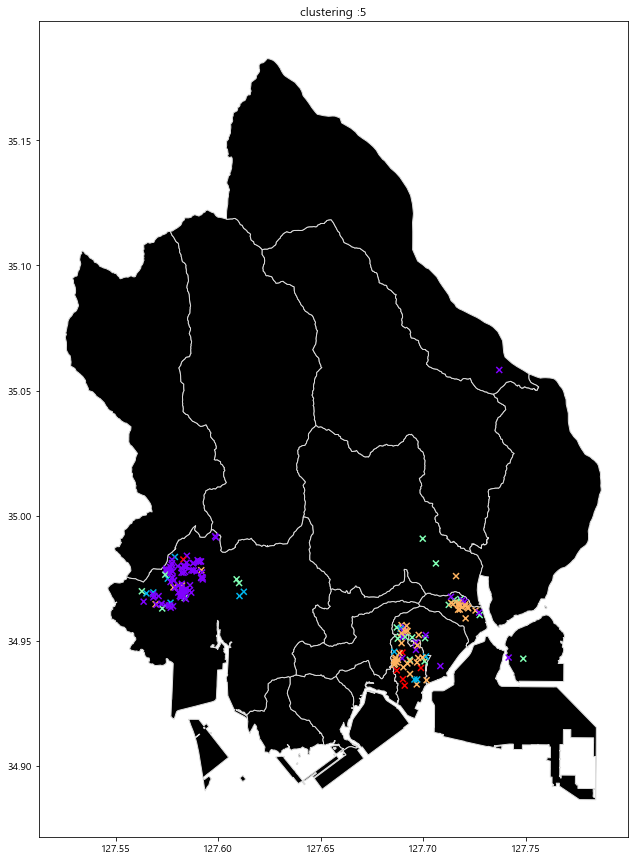

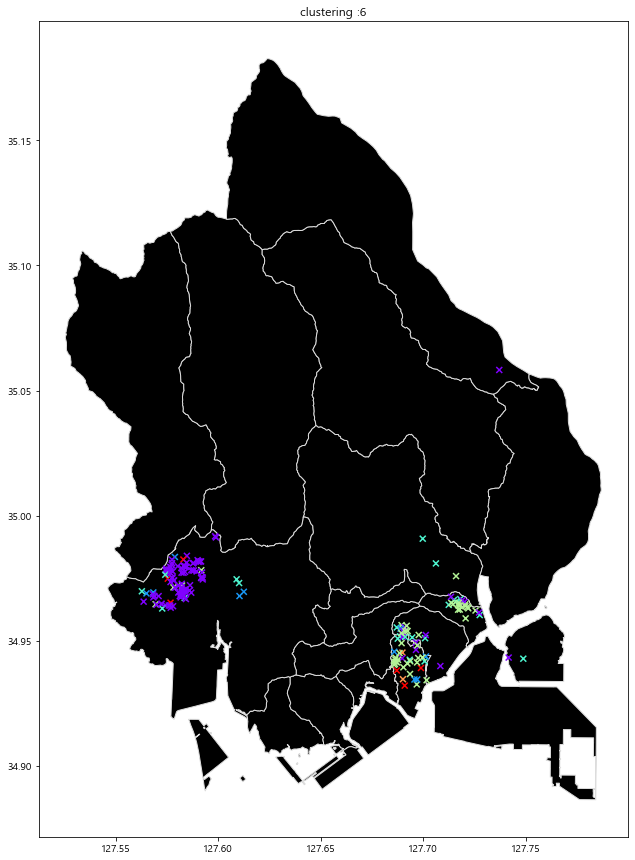

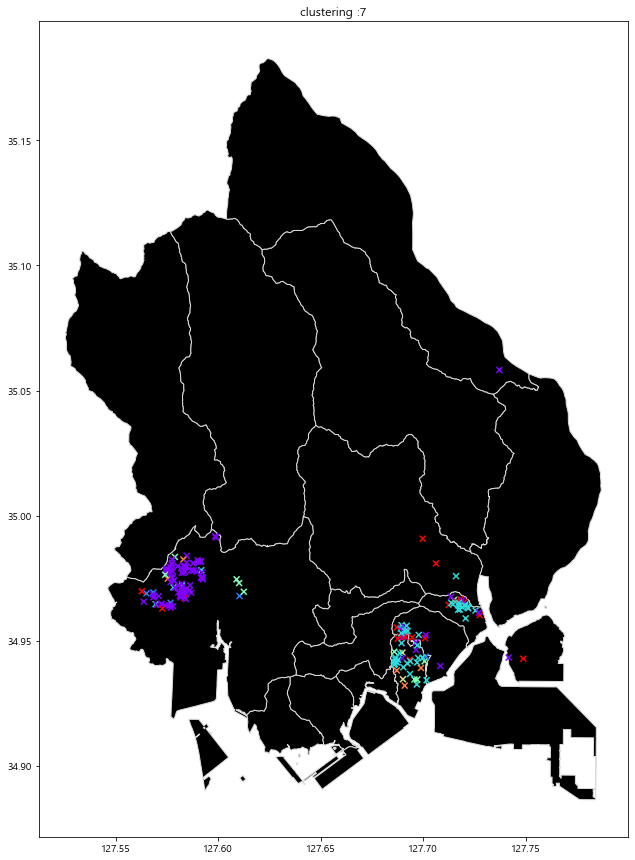

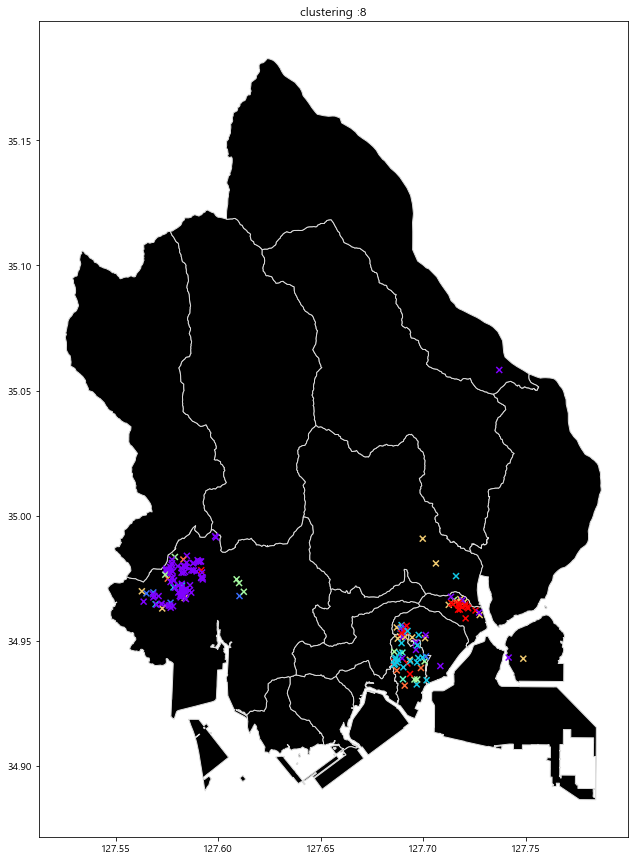

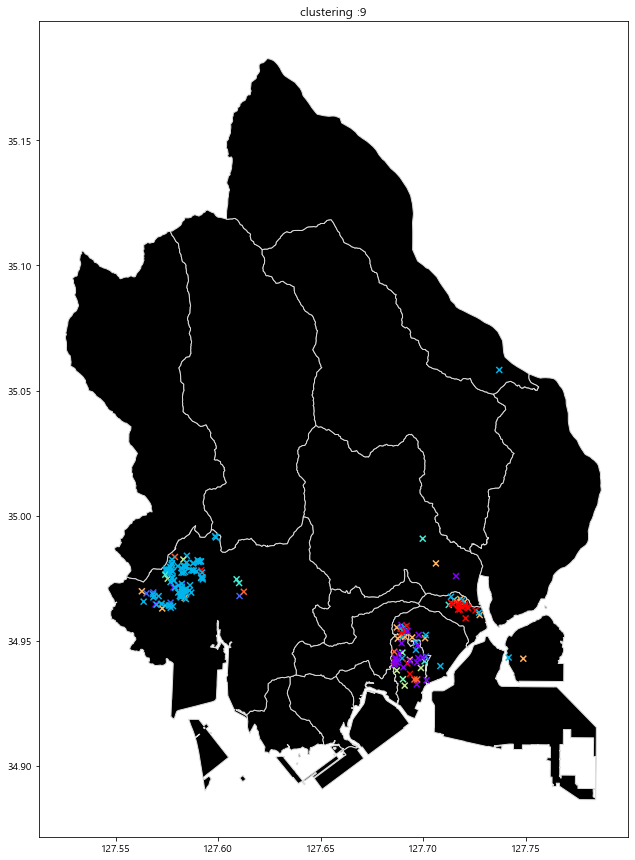

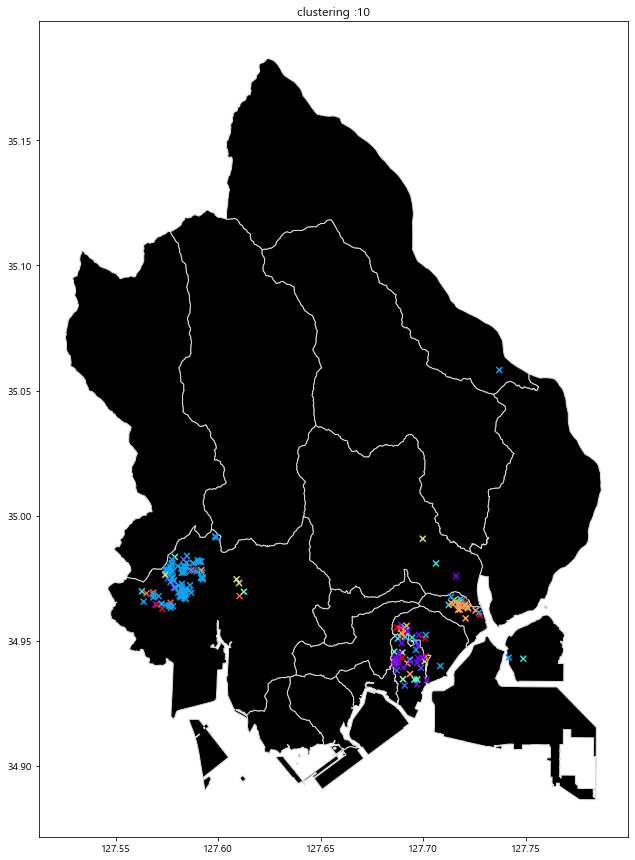

In [26]:
# K값에 따른 시각화 ( 5~ 11 )

for i in range(5, 11):
    ax = a.plot(figsize = (15, 15), column = 'emd_nm', color = 'black', edgecolor='gainsboro')
    kmeans = KMeans(n_clusters=i, n_init=20).fit_predict(geo_final[['household_cnt', '추정거주인구', 'subsidy', 'A_recycle', 'B_recycle']])
    geo_final['cluster']=kmeans
    geo_final.plot(column='cluster',cmap='rainbow',figsize=(10, 10), marker = 'x', ax = ax)
    ax.set_title('clustering :{}'.format(i))

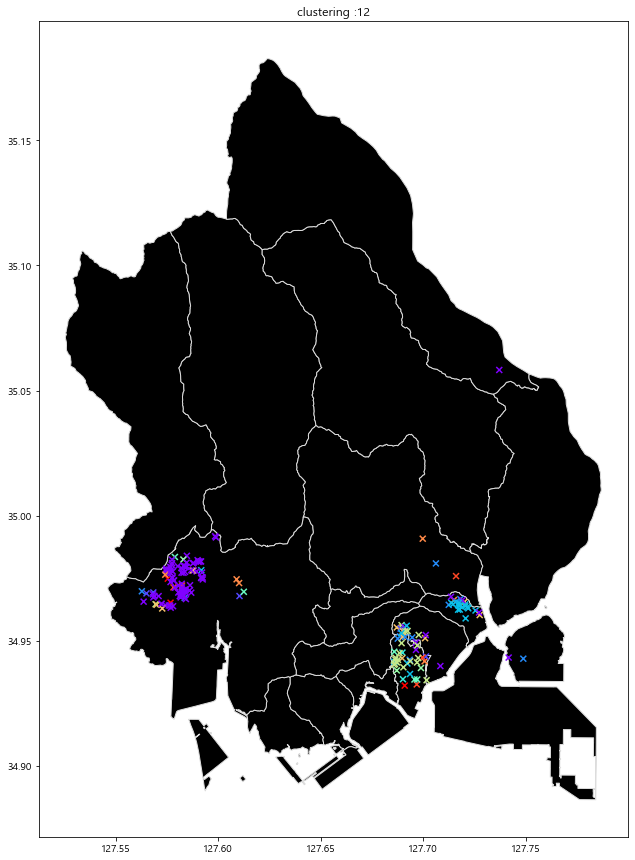

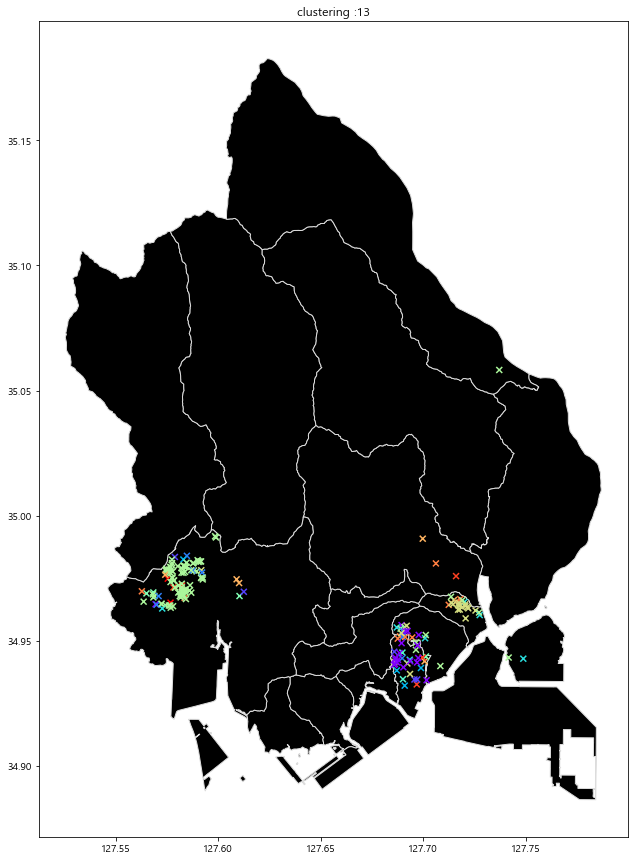

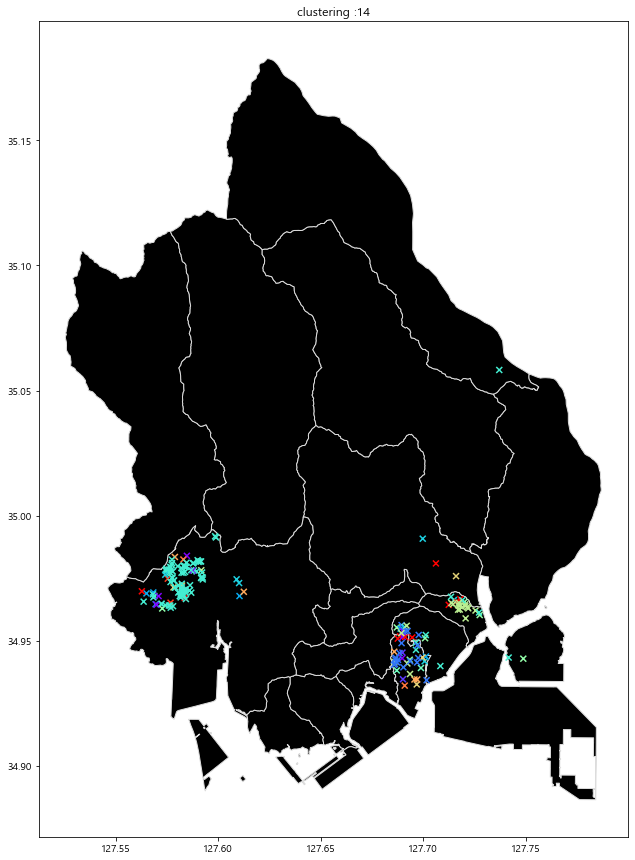

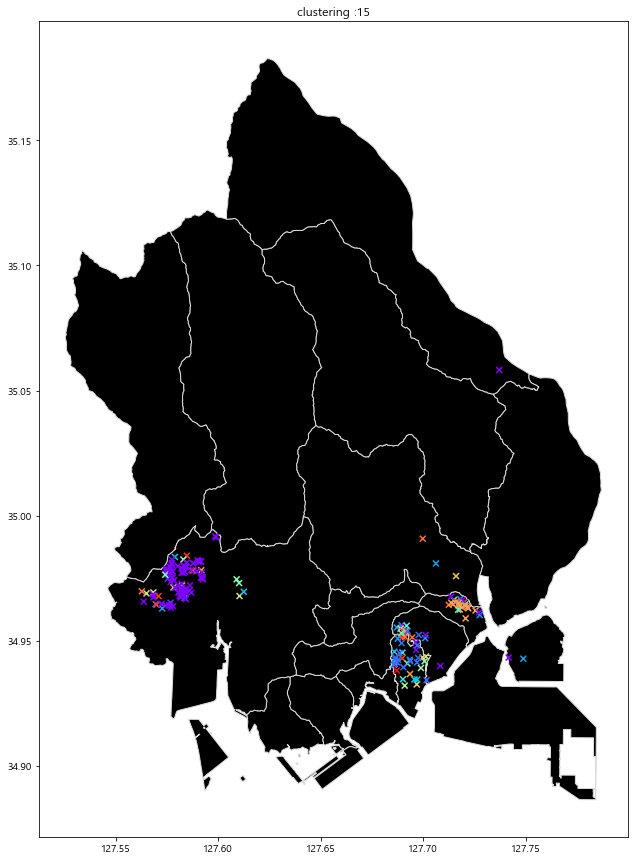

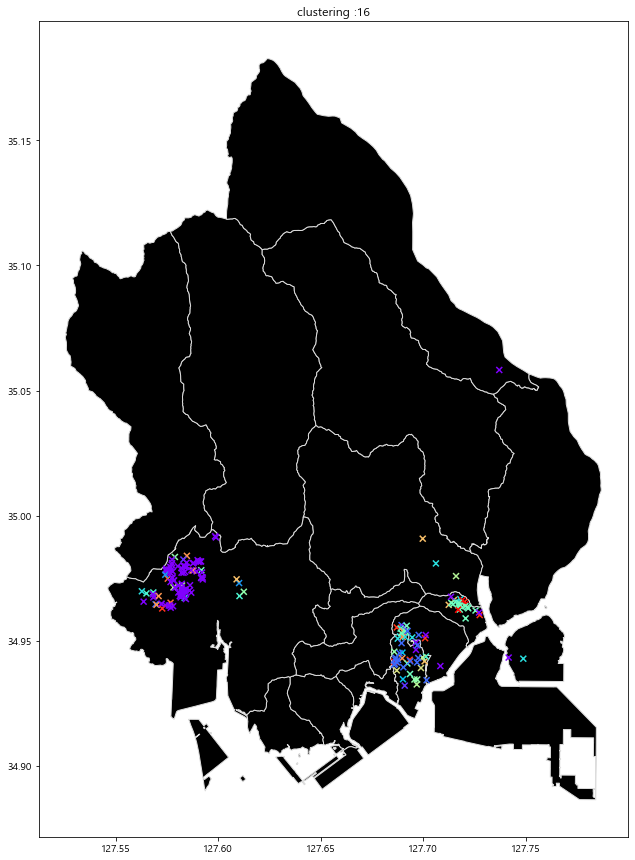

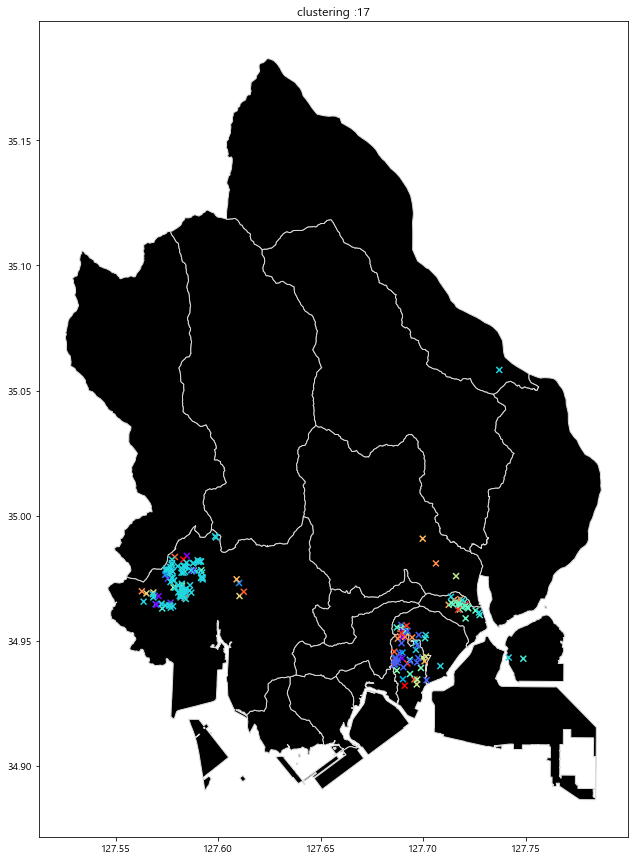

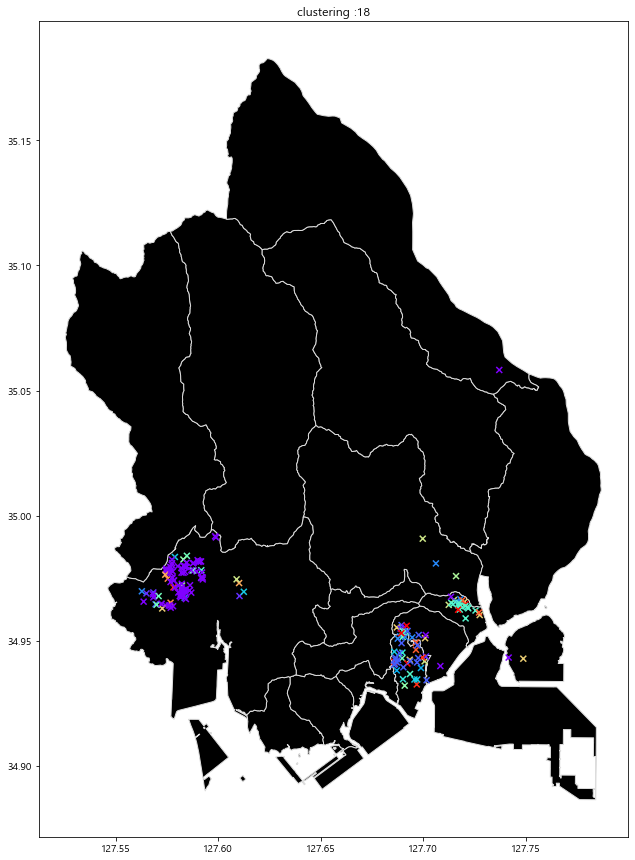

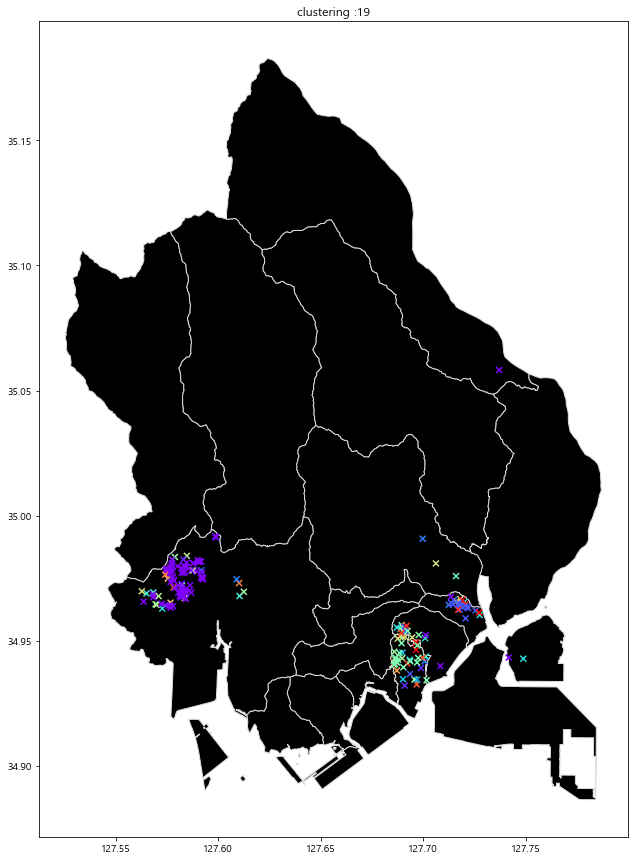

In [27]:
# K값에 따른 시각화 (12 , 20)

for i in range(12, 20):
    ax = a.plot(figsize = (15, 15), column = 'emd_nm', color = 'black', edgecolor='gainsboro')
    kmeans = KMeans(n_clusters=i, n_init=20).fit_predict(geo_final[['household_cnt', '추정거주인구', 'subsidy', 'A_recycle', 'B_recycle']])
    geo_final['cluster']=kmeans
    geo_final.plot(column='cluster',cmap='rainbow',figsize=(10, 10), marker = 'x', ax = ax)
    ax.set_title('clustering :{}'.format(i))

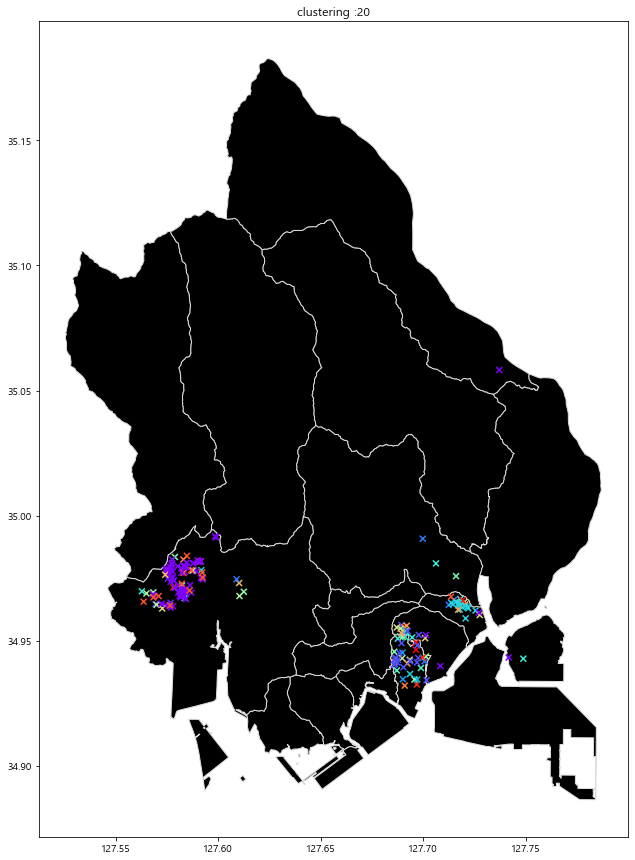

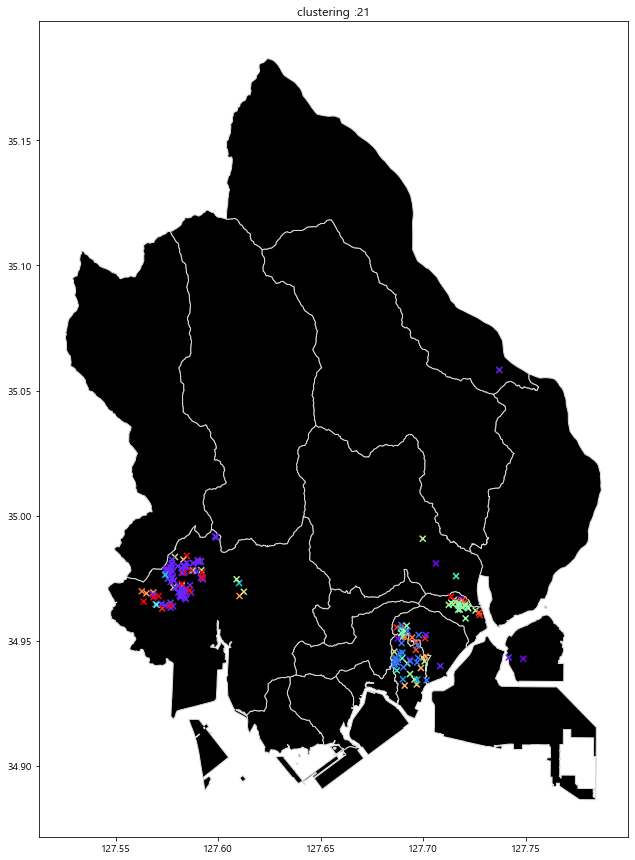

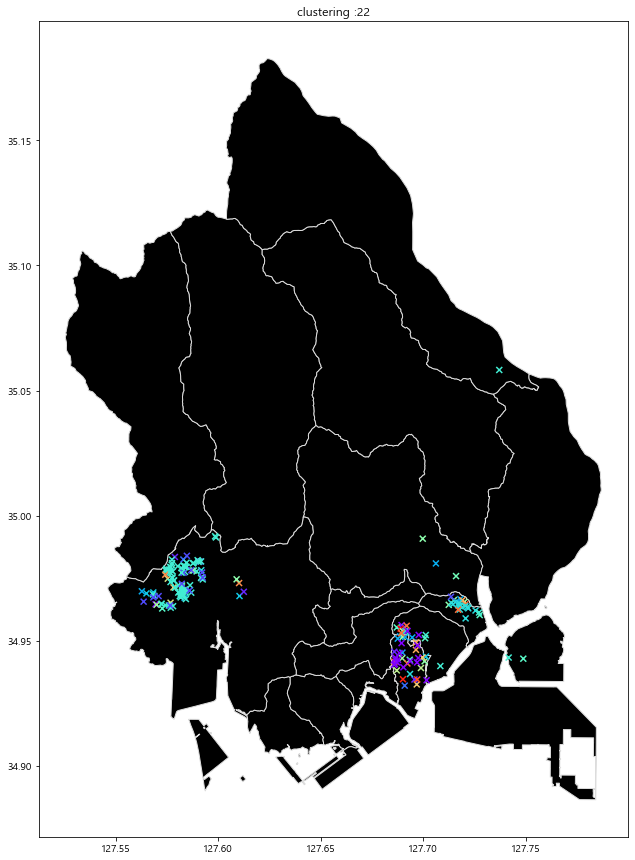

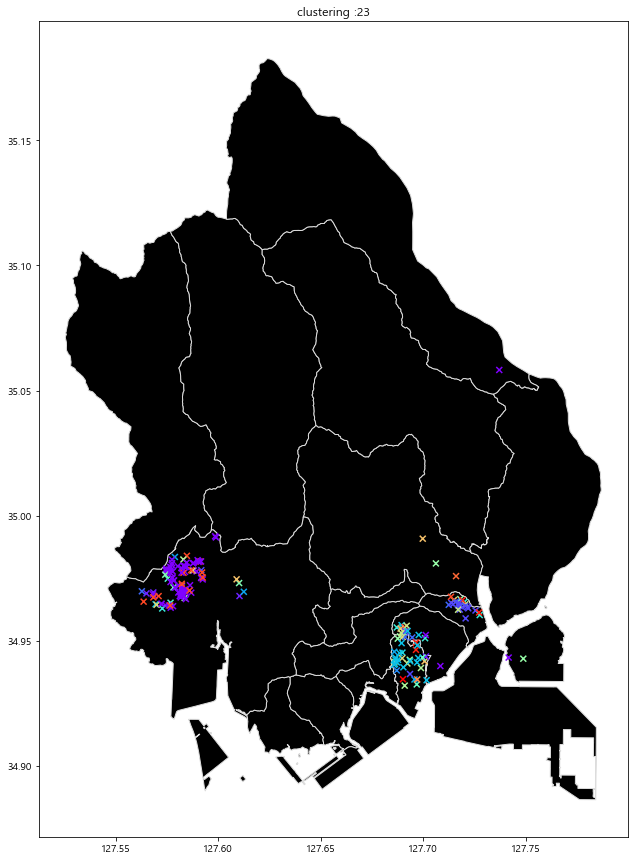

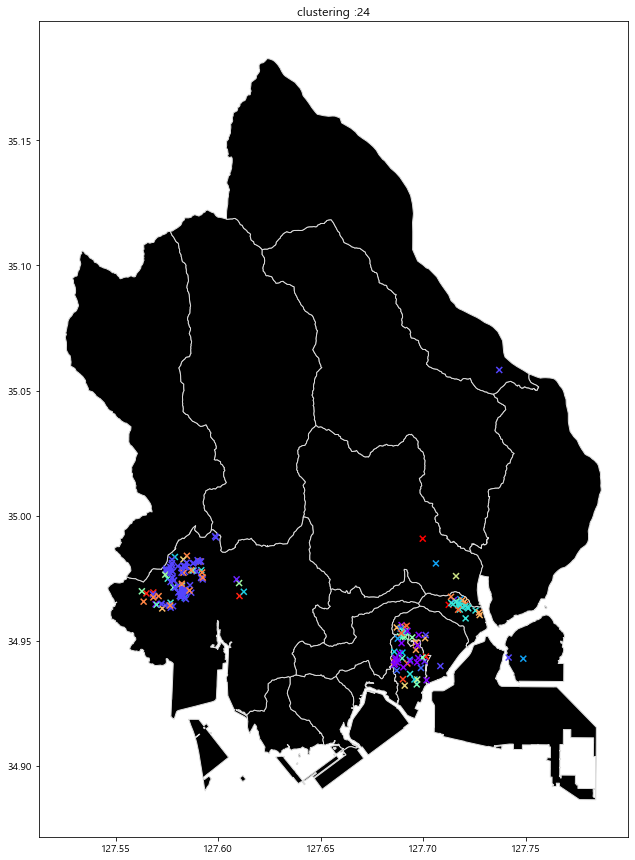

In [28]:
# K값에 따른 시각화 ( 20 ~ 25 )

for i in range(20, 25):
    ax = a.plot(figsize = (15, 15), column = 'emd_nm', color = 'black', edgecolor='gainsboro')
    kmeans = KMeans(n_clusters=i, n_init=20).fit_predict(geo_final[['household_cnt', '추정거주인구', 'subsidy', 'A_recycle', 'B_recycle']])
    geo_final['cluster']=kmeans
    geo_final.plot(column='cluster',cmap='rainbow',figsize=(10, 10), marker = 'x', ax = ax)
    ax.set_title('clustering :{}'.format(i))

## 최적 k값 : 15

## 5. 수거기 최적 위치 선정

### 5.1 각 Feature별 가중치 값 찾기

In [29]:
final_cluster['sum_recycle'] = final_cluster['A_recycle'] + final_cluster['B_recycle']


sum_recycle_point = np.linspace(final_cluster['sum_recycle'].min(), final_cluster['sum_recycle'].max(), num = 5)
subsidy_point = np.linspace(final_cluster['subsidy'].min(), final_cluster['subsidy'].max(), num = 5)
household_cnt_point = np.linspace(final_cluster['household_cnt'].min(), final_cluster['household_cnt'].max(), num = 5)
추정거주인구_point = np.linspace(final_cluster['추정거주인구'].min(), final_cluster['추정거주인구'].max(), num = 5)
A_recycle_point = np.linspace(final_cluster['A_recycle'].min(), final_cluster['A_recycle'].max(), num = 5)
B_recycle_point = np.linspace(final_cluster['B_recycle'].min(), final_cluster['B_recycle'].max(), num = 5)

print('sum_recycle_point :', sum_recycle_point)
print('subsidy_point : ', subsidy_point)
print('householed_cnt_point : ', household_cnt_point)
print('추정거주인구_point : ', 추정거주인구_point)
print('A_recycle_point : ', A_recycle_point)
print('B_recycle_point : ', B_recycle_point)

sum_recycle_point : [  200.   12434.25 24668.5  36902.75 49137.  ]
subsidy_point :  [  18860.   818462.5 1618065.  2417667.5 3217270. ]
householed_cnt_point :  [4.00000e+00 1.02125e+03 2.03850e+03 3.05575e+03 4.07300e+03]
추정거주인구_point :  [9.0400000e+00 2.5829525e+03 5.1568650e+03 7.7307775e+03 1.0304690e+04]
A_recycle_point :  [    0. 12022. 24044. 36066. 48088.]
B_recycle_point :  [   0.   2282.25 4564.5  6846.75 9129.  ]


In [30]:
final_cluster = final_cluster[['bldg_nm', 'land_location', 'bun', 'ji', 'main_annex_gbn', 'purpose_nm',
       'etc_purpose_nm', 'lon', 'lat', 'household_cnt', 'sum_recycle', '추정거주인구',
       'A_recycle', 'B_recycle', 'subsidy', 'Cluster_15']]
final_cluster= final_cluster.rename(columns ={'추정거주인구' : 'pop_pred'})

In [31]:
feature_list = ['sum_recycle', 'A_recycle', 'household_cnt', 'pop_pred', 'subsidy', 'B_recycle']
for i in feature_list:
    data = final_cluster[i]
    breaks = []
    
    for x in np.linspace(np.min(data),np.max(data), 5):
        es = x
        breaks.append(es)
        

    breaks.sort()
    print(breaks)
    
    feature_name = str(i + '_point')
    final_cluster[feature_name] = pd.cut(final_cluster[i], bins = breaks, labels = [1, 2, 3, 4], include_lowest = True).astype('float64')

[200.0, 12434.25, 24668.5, 36902.75, 49137.0]
[0.0, 12022.0, 24044.0, 36066.0, 48088.0]
[4.0, 1021.25, 2038.5, 3055.75, 4073.0]
[9.04, 2582.9524999999994, 5156.864999999999, 7730.777499999998, 10304.689999999999]
[18860.0, 818462.5, 1618065.0, 2417667.5, 3217270.0]
[0.0, 2282.25, 4564.5, 6846.75, 9129.0]


In [32]:
final_cluster['total_point'] = final_cluster[['sum_recycle_point', 'A_recycle_point',
                                'household_cnt_point', 'pop_pred_point', 'subsidy_point', 'B_recycle_point']].sum(axis = 1)

## 5.2 구간별 점수화

In [33]:
# 특성 weight 주기(반드시 한번만 실행시켜야 함!)

weight_list = [1.5, 1.5, 1, 1, 1, 0.7]
feature_list = ['sum_recycle_point', 'household_cnt_point', 'A_recycle_point',
                'pop_pred_point', 'subsidy_point', 'B_recycle_point']

for i in range(6):
    final_cluster[feature_list[i]] = final_cluster[feature_list[i]] * weight_list[i]

In [34]:
point_table = final_cluster.groupby(['Cluster_15'])['sum_recycle_point', 'A_recycle_point',
                                                 'household_cnt_point', 'pop_pred_point', 'subsidy_point', 'B_recycle_point'].mean()
point_table['total'] = point_table.sum(axis = 1)
point_table.sort_values(by =  'total', ascending = False, inplace = True)
point_table

,sum_recycle_point,A_recycle_point,household_cnt_point,pop_pred_point,subsidy_point,B_recycle_point,total
Cluster_15,,,,,,,
14,5.500000,3.666667,3.50,2.333333,3.333333,1.400000,19.733333
5,5.250000,3.000000,2.25,1.500000,4.000000,1.750000,17.750000
4,6.000000,4.000000,1.50,1.000000,4.000000,0.700000,17.200000
9,4.500000,3.000000,1.50,1.000000,3.000000,1.750000,14.750000
1,4.200000,2.400000,1.50,1.000000,3.000000,1.820000,13.920000
6,3.000000,2.000000,2.25,1.500000,2.000000,1.050000,11.800000
10,3.600000,2.200000,1.50,1.000000,2.200000,1.260000,11.760000
3,3.000000,2.000000,1.50,1.000000,2.000000,1.120000,10.620000
7,3.000000,1.666667,1.75,1.166667,2.000000,0.816667,10.400000


In [35]:
final_cluster['Cluster_15'].value_counts()

0     93
8     20
2     20
13    10
12     7
7      6
11     5
10     5
3      5
1      5
14     3
9      2
6      2
5      2
4      1
Name: Cluster_15, dtype: int64

In [36]:
dd = final_cluster.loc[final_cluster.bldg_nm == 'sdf']
cluster_list = point_table.index.to_list()
res = []
a= 0
for i in range(15):
    tmp = final_cluster[(final_cluster.Cluster_15 == cluster_list[i])]
    a += len(tmp)
    res.append(cluster_list[i])
    print(a)
    top_list = final_cluster
    if a >= 38 :
        break
        
print(res)

a = len(res)
for i in res:
    dd = dd.append(final_cluster[(final_cluster.Cluster_15 == i)])
    dd.loc[dd.Cluster_15 == i, 'Cluster_rank'] = a
    a -= 1
        
        
dd.info()

3
5
6
8
13
15
20
25
31
41
[14, 5, 4, 9, 1, 6, 10, 3, 7, 13]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 89 to 181
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bldg_nm              41 non-null     object 
 1   land_location        41 non-null     object 
 2   bun                  41 non-null     object 
 3   ji                   41 non-null     object 
 4   main_annex_gbn       41 non-null     object 
 5   purpose_nm           41 non-null     object 
 6   etc_purpose_nm       41 non-null     object 
 7   lon                  41 non-null     float64
 8   lat                  41 non-null     float64
 9   household_cnt        41 non-null     int64  
 10  sum_recycle          41 non-null     float64
 11  pop_pred             41 non-null     float64
 12  A_recycle            41 non-null     float64
 13  B_recycle            41 non-null     float64
 14  subsidy              41 non-nu

In [37]:
dd['recommend_point'] = (dd['Cluster_rank'] * 3) + dd['total_point']
dd = dd[:38]
not_geumho_list = dd[['bldg_nm', 'lon', 'lat']]
not_geumho_list = not_geumho_list.reset_index()
not_geumho_list = not_geumho_list.drop('index', axis = 1)

## 5.3 결과

In [38]:
not_geumho_list

,bldg_nm,lon,lat
0,성호2차아파트,127.690977,34.932170
1,e편한세상광양아파트,127.698898,34.939212
2,칠성주공아파트,127.583055,34.982528
3,무등파크맨션아파트,127.689866,34.945355
4,금광1차아파트,127.690114,34.934728
5,진아리채2차아파트,127.687123,34.938236
6,오성타워맨션아파트,127.576791,34.965288
7,칠성e-편한세상아파트,127.575439,34.974893
8,대림아파트,127.565044,34.969006
9,남해오네뜨,127.610419,34.967952


# 6. 금호동

In [39]:
final1_geumho

,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,geometry,추정거주인구,A_recycle,B_recycle,subsidy
48,목련빌라,전라남도 광양시 금호동,"""0684""","""0000""",주건축물,공동주택,빌라,127.728429,34.940589,567,"MULTIPOLYGON (((127.72775 34.94211, 127.72794 ...",1377.81,NaN,NaN,NaN
127,송죽아파트,전라남도 광양시 금호동,"""0826""","""0000""",주건축물,공동주택,아파트,127.718450,34.939268,210,"MULTIPOLYGON (((127.71781 34.93938, 127.71798 ...",510.30,NaN,NaN,NaN
133,사랑아파트,전라남도 광양시 금호동,"""0624""","""0013""",주건축물,공동주택,아파트,127.717120,34.934343,903,"MULTIPOLYGON (((127.71721 34.93542, 127.71726 ...",2194.29,NaN,NaN,NaN
173,동백아파트,전라남도 광양시 금호동,"""0712""","""0000""",주건축물,공동주택,아파트,127.731015,34.936385,350,"MULTIPOLYGON (((127.58587 34.97051, 127.58621 ...",850.50,NaN,NaN,NaN
175,매화아파트,전라남도 광양시 금호동,"""0624""","""0007""",주건축물,공동주택,아파트,127.720397,34.936325,572,"MULTIPOLYGON (((127.72216 34.93669, 127.72216 ...",1389.96,NaN,NaN,NaN
176,초원아파트,전라남도 광양시 금호동,"""0825""","""0000""",주건축물,공동주택,아파트,127.720248,34.938398,336,"MULTIPOLYGON (((127.71945 34.93761, 127.71951 ...",816.48,NaN,NaN,NaN
177,백합아파트,전라남도 광양시 금호동,"""0624""","""0001""",주건축물,공동주택,아파트,127.723044,34.933698,852,"MULTIPOLYGON (((127.72497 34.93556, 127.72505 ...",2070.36,NaN,NaN,NaN
179,목련연립아파트,전라남도 광양시 금호동,"""0717""","""0000""",주건축물,공동주택,아파트,127.732675,34.937696,626,"MULTIPOLYGON (((127.73374 34.93851, 127.73379 ...",1521.18,NaN,NaN,NaN
194,장미연립아파트,전라남도 광양시 금호동,"""0725""","""0000""",주건축물,공동주택,아파트,127.733266,34.941267,833,"MULTIPOLYGON (((127.73221 34.94208, 127.73278 ...",2024.19,NaN,NaN,NaN


## 6.1 주요배출항목(A_recycle) 보간

In [40]:
train = final1.loc[final1['subsidy'].notnull()]
test = final1_geumho.loc[final1_geumho['subsidy'].isna()]


X_train = train[['land_location', 'household_cnt', '추정거주인구']]
X_train = pd.get_dummies(X_train)

X_test = test[['land_location', 'household_cnt', '추정거주인구']]
X_test = pd.get_dummies(X_test)

X_test['land_location_전라남도 광양시 광양읍'] = 0
X_test['land_location_전라남도 광양시 광영동'] = 0
X_test['land_location_전라남도 광양시 옥곡면'] = 0
X_test['land_location_전라남도 광양시 중마동'] = 0
X_test['land_location_전라남도 광양시 태인동'] = 0
X_test = X_test.drop('land_location_전라남도 광양시 금호동', axis = 1)



y_train = train['A_recycle']
y_test = test['A_recycle']

model_ridge = Ridge(solver = 'svd', alpha = 1).fit(X_train, y_train)

ridge_pred_A_recycle = model_ridge.predict(X_test)
ridge_pred_A_recycle

array([10337.02100458,  8021.54355716, 12516.29389628,  8929.5739287 ,
       10369.45066071,  8838.77089154, 12185.51140379, 10719.69094688,
       12062.27871051])

In [41]:
model_ridge = Ridge(solver = 'svd', alpha = 1).fit(X_train, y_train)

ridge_pred_A_recycle = model_ridge.predict(X_test)
ridge_pred_A_recycle

array([10337.02100458,  8021.54355716, 12516.29389628,  8929.5739287 ,
       10369.45066071,  8838.77089154, 12185.51140379, 10719.69094688,
       12062.27871051])

## 6.2 기타배출항목(B_recycle) 보간 

In [42]:
y_train = train['B_recycle']
y_test = test['B_recycle']

model_ridge = Ridge(solver = 'svd', alpha = .1).fit(X_train, y_train)

ridge_pred_B_recycle = model_ridge.predict(X_test)
ridge_pred_B_recycle

array([1199.05362837,  715.14376538, 1654.49820529,  904.9123391 ,
       1205.83107743,  885.93548173, 1585.36822487, 1279.02752729,
       1559.61391843])

## 6.3 총 장려금교부액(subsidy) 보간

In [43]:
y_train = train['subsidy']
y_test = test['subsidy']

model_ridge = Ridge(solver = 'svd', alpha = .1).fit(X_train, y_train)

ridge_pred_subsidy = model_ridge.predict(X_test)
ridge_pred_subsidy

array([410036.23717881, 191599.32127208, 615623.92273809, 277260.85692178,
       413095.57773773, 268694.70335681, 584418.64903712, 446136.45577404,
       572793.15491324])

### 합

In [44]:
test['ridge_pred_subsidy'] = ridge_pred_subsidy
test['ridge_pred_A_recycle'] = ridge_pred_A_recycle
test['ridge_pred_B_recycle'] = ridge_pred_B_recycle

test = test.drop(['A_recycle', 'B_recycle', 'subsidy'], axis = 1)

test = test.rename(columns = {'ridge_pred_B_recycle': 'B_recycle'})
test = test.rename(columns = {'ridge_pred_A_recycle' : 'A_recycle'})
test = test.rename(columns = {'ridge_pred_subsidy' : 'subsidy'})

final_geumho = test
final_geumho

,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,geometry,추정거주인구,subsidy,A_recycle,B_recycle
48,목련빌라,전라남도 광양시 금호동,"""0684""","""0000""",주건축물,공동주택,빌라,127.728429,34.940589,567,"MULTIPOLYGON (((127.72775 34.94211, 127.72794 ...",1377.81,410036.237179,10337.021005,1199.053628
127,송죽아파트,전라남도 광양시 금호동,"""0826""","""0000""",주건축물,공동주택,아파트,127.718450,34.939268,210,"MULTIPOLYGON (((127.71781 34.93938, 127.71798 ...",510.30,191599.321272,8021.543557,715.143765
133,사랑아파트,전라남도 광양시 금호동,"""0624""","""0013""",주건축물,공동주택,아파트,127.717120,34.934343,903,"MULTIPOLYGON (((127.71721 34.93542, 127.71726 ...",2194.29,615623.922738,12516.293896,1654.498205
173,동백아파트,전라남도 광양시 금호동,"""0712""","""0000""",주건축물,공동주택,아파트,127.731015,34.936385,350,"MULTIPOLYGON (((127.58587 34.97051, 127.58621 ...",850.50,277260.856922,8929.573929,904.912339
175,매화아파트,전라남도 광양시 금호동,"""0624""","""0007""",주건축물,공동주택,아파트,127.720397,34.936325,572,"MULTIPOLYGON (((127.72216 34.93669, 127.72216 ...",1389.96,413095.577738,10369.450661,1205.831077
176,초원아파트,전라남도 광양시 금호동,"""0825""","""0000""",주건축물,공동주택,아파트,127.720248,34.938398,336,"MULTIPOLYGON (((127.71945 34.93761, 127.71951 ...",816.48,268694.703357,8838.770892,885.935482
177,백합아파트,전라남도 광양시 금호동,"""0624""","""0001""",주건축물,공동주택,아파트,127.723044,34.933698,852,"MULTIPOLYGON (((127.72497 34.93556, 127.72505 ...",2070.36,584418.649037,12185.511404,1585.368225
179,목련연립아파트,전라남도 광양시 금호동,"""0717""","""0000""",주건축물,공동주택,아파트,127.732675,34.937696,626,"MULTIPOLYGON (((127.73374 34.93851, 127.73379 ...",1521.18,446136.455774,10719.690947,1279.027527
194,장미연립아파트,전라남도 광양시 금호동,"""0725""","""0000""",주건축물,공동주택,아파트,127.733266,34.941267,833,"MULTIPOLYGON (((127.73221 34.94208, 127.73278 ...",2024.19,572793.154913,12062.278711,1559.613918


## 6.4 각 Feature 가중치 값 산정 및 구간화

In [45]:
final_cluster = final_geumho

final_cluster['sum_recycle'] = final_cluster['A_recycle'] + final_cluster['B_recycle']


sum_recycle_point = np.linspace(final_cluster['sum_recycle'].min(), final_cluster['sum_recycle'].max(), num = 5)
subsidy_point = np.linspace(final_cluster['subsidy'].min(), final_cluster['subsidy'].max(), num = 5)
household_cnt_point = np.linspace(final_cluster['household_cnt'].min(), final_cluster['household_cnt'].max(), num = 5)
추정거주인구_point = np.linspace(final_cluster['추정거주인구'].min(), final_cluster['추정거주인구'].max(), num = 5)
A_recycle_point = np.linspace(final_cluster['A_recycle'].min(), final_cluster['A_recycle'].max(), num = 5)
B_recycle_point = np.linspace(final_cluster['B_recycle'].min(), final_cluster['B_recycle'].max(), num = 5)

print('sum_recycle_point :', sum_recycle_point)
print('subsidy_point : ', subsidy_point)
print('householed_cnt_point : ', household_cnt_point)
print('추정거주인구_point : ', 추정거주인구_point)
print('A_recycle_point : ', A_recycle_point)
print('B_recycle_point : ', B_recycle_point)

final_cluster = final_cluster[['bldg_nm', 'land_location', 'bun', 'ji', 'main_annex_gbn', 'purpose_nm',
       'etc_purpose_nm', 'lon', 'lat', 'household_cnt', 'sum_recycle', '추정거주인구',
       'A_recycle', 'B_recycle', 'subsidy']]
final_cluster= final_cluster.rename(columns ={'추정거주인구' : 'pop_pred'})



sum_recycle_point : [ 8736.68732254 10095.2135173  11453.73971205 12812.26590681
 14170.79210157]
subsidy_point :  [191599.32127208 297605.47163858 403611.62200508 509617.77237158
 615623.92273809]
householed_cnt_point :  [210.   383.25 556.5  729.75 903.  ]
추정거주인구_point :  [ 510.3     931.2975 1352.295  1773.2925 2194.29  ]
A_recycle_point :  [ 8021.54355716  9145.23114194 10268.91872672 11392.6063115
 12516.29389628]
B_recycle_point :  [ 715.14376538  949.98237536 1184.82098534 1419.65959531 1654.49820529]


In [46]:
feature_list = ['sum_recycle', 'A_recycle', 'household_cnt', 'pop_pred', 'subsidy', 'B_recycle']
for i in feature_list:
    data = final_cluster[i]
    breaks = []
    
    for x in np.linspace(np.min(data),np.max(data), 5):
        es = x
        breaks.append(es)
        

    breaks.sort()
    print(breaks)
    
    feature_name = str(i + '_point')
    final_cluster[feature_name] = pd.cut(final_cluster[i], bins = breaks, labels = [1, 2, 3, 4], include_lowest = True).astype('float64')

[8736.68732253925, 10095.21351729706, 11453.739712054867, 12812.265906812674, 14170.792101570483]
[8021.543557156356, 9145.23114193705, 10268.918726717744, 11392.606311498439, 12516.293896279134]
[210.0, 383.25, 556.5, 729.75, 903.0]
[510.3, 931.2975, 1352.295, 1773.2925, 2194.29]
[191599.32127208216, 297605.47163858294, 403611.6220050837, 509617.7723715845, 615623.9227380853]
[715.143765382895, 949.9823753600087, 1184.8209853371225, 1419.6595953142362, 1654.49820529135]


In [47]:
final_cluster['total_point'] = final_cluster[['sum_recycle_point', 'A_recycle_point',
                                'household_cnt_point', 'pop_pred_point', 'subsidy_point', 'B_recycle_point']].sum(axis = 1)

In [48]:
# 특성 weight 주기(반드시 한번만 실행시켜야 함!)

weight_list = [1.5,1.5,1,1,1,0.7]
feature_list = ['sum_recycle_point', 'household_cnt_point', 'A_recycle_point',
                'pop_pred_point', 'subsidy_point', 'B_recycle_point']

for i in range(6):
    final_cluster[feature_list[i]] = final_cluster[feature_list[i]] * weight_list[i]

In [49]:
final_cluster

,bldg_nm,land_location,bun,ji,main_annex_gbn,purpose_nm,etc_purpose_nm,lon,lat,household_cnt,sum_recycle,pop_pred,A_recycle,B_recycle,subsidy,sum_recycle_point,A_recycle_point,household_cnt_point,pop_pred_point,subsidy_point,B_recycle_point,total_point
48,목련빌라,전라남도 광양시 금호동,"""0684""","""0000""",주건축물,공동주택,빌라,127.728429,34.940589,567,11536.074633,1377.81,10337.021005,1199.053628,410036.237179,4.5,3.0,4.5,3.0,3.0,2.1,18.0
127,송죽아파트,전라남도 광양시 금호동,"""0826""","""0000""",주건축물,공동주택,아파트,127.718450,34.939268,210,8736.687323,510.30,8021.543557,715.143765,191599.321272,1.5,1.0,1.5,1.0,1.0,0.7,6.0
133,사랑아파트,전라남도 광양시 금호동,"""0624""","""0013""",주건축물,공동주택,아파트,127.717120,34.934343,903,14170.792102,2194.29,12516.293896,1654.498205,615623.922738,6.0,4.0,6.0,4.0,4.0,2.8,24.0
173,동백아파트,전라남도 광양시 금호동,"""0712""","""0000""",주건축물,공동주택,아파트,127.731015,34.936385,350,9834.486268,850.50,8929.573929,904.912339,277260.856922,1.5,1.0,1.5,1.0,1.0,0.7,6.0
175,매화아파트,전라남도 광양시 금호동,"""0624""","""0007""",주건축물,공동주택,아파트,127.720397,34.936325,572,11575.281738,1389.96,10369.450661,1205.831077,413095.577738,4.5,3.0,4.5,3.0,3.0,2.1,18.0
176,초원아파트,전라남도 광양시 금호동,"""0825""","""0000""",주건축물,공동주택,아파트,127.720248,34.938398,336,9724.706373,816.48,8838.770892,885.935482,268694.703357,1.5,1.0,1.5,1.0,1.0,0.7,6.0
177,백합아파트,전라남도 광양시 금호동,"""0624""","""0001""",주건축물,공동주택,아파트,127.723044,34.933698,852,13770.879629,2070.36,12185.511404,1585.368225,584418.649037,6.0,4.0,6.0,4.0,4.0,2.8,24.0
179,목련연립아파트,전라남도 광양시 금호동,"""0717""","""0000""",주건축물,공동주택,아파트,127.732675,34.937696,626,11998.718474,1521.18,10719.690947,1279.027527,446136.455774,4.5,3.0,4.5,3.0,3.0,2.1,18.0
194,장미연립아파트,전라남도 광양시 금호동,"""0725""","""0000""",주건축물,공동주택,아파트,127.733266,34.941267,833,13621.892629,2024.19,12062.278711,1559.613918,572793.154913,6.0,4.0,6.0,4.0,4.0,2.8,24.0


In [50]:
geumho_list = final_cluster.reset_index()
geumho_list = geumho_list.drop('index', axis = 1)
geumho_list = geumho_list[['bldg_nm', 'lon', 'lat']]

## 6.5 결과

In [51]:
geumho_list

,bldg_nm,lon,lat
0,목련빌라,127.728429,34.940589
1,송죽아파트,127.718450,34.939268
2,사랑아파트,127.717120,34.934343
3,동백아파트,127.731015,34.936385
4,매화아파트,127.720397,34.936325
5,초원아파트,127.720248,34.938398
6,백합아파트,127.723044,34.933698
7,목련연립아파트,127.732675,34.937696
8,장미연립아파트,127.733266,34.941267


## Score top 3인'사랑아파트', '백합아파트', '장미연립아파트' 수거기 2개 설치

In [52]:
final_list = pd.concat([geumho_list, not_geumho_list])

In [53]:
geumho_list = geumho_list.loc[geumho_list.bldg_nm != '사랑아파트']
geumho_list = geumho_list.loc[geumho_list.bldg_nm != '백합아파트']
geumho_list = geumho_list.loc[geumho_list.bldg_nm != '장미연립아파트']

In [54]:
s1 = ['사랑아파트1', 127.717120, 34.934343]
s2 = ['사랑아파트2', 127.717120, 34.934343]
b1 = ['백합아파트1', 127.723044, 34.933698]
b2 = ['백합아파트2', 127.723044, 34.933698]
j1 = ['장미연립아파트1', 127.733266, 34.941267]
j2 = ['장미연립아파트2', 127.733266, 34.941267]

In [55]:
geumho_list = geumho_list.append(pd.Series(j1, index = geumho_list.columns), ignore_index = True)
geumho_list

,bldg_nm,lon,lat
0,목련빌라,127.728429,34.940589
1,송죽아파트,127.718450,34.939268
2,동백아파트,127.731015,34.936385
3,매화아파트,127.720397,34.936325
4,초원아파트,127.720248,34.938398
5,목련연립아파트,127.732675,34.937696
6,장미연립아파트1,127.733266,34.941267


In [56]:
geumho_list = geumho_list.reset_index()
geumho_list = geumho_list.drop('index', axis = 1)
geumho_list

,bldg_nm,lon,lat
0,목련빌라,127.728429,34.940589
1,송죽아파트,127.718450,34.939268
2,동백아파트,127.731015,34.936385
3,매화아파트,127.720397,34.936325
4,초원아파트,127.720248,34.938398
5,목련연립아파트,127.732675,34.937696
6,장미연립아파트1,127.733266,34.941267


In [57]:
final_list = pd.concat([geumho_list, not_geumho_list])
final_list = final_list.reset_index()
final_list = final_list.drop('index', axis = 1)
final_list

,bldg_nm,lon,lat
0,목련빌라,127.728429,34.940589
1,송죽아파트,127.718450,34.939268
2,동백아파트,127.731015,34.936385
3,매화아파트,127.720397,34.936325
4,초원아파트,127.720248,34.938398
5,목련연립아파트,127.732675,34.937696
6,장미연립아파트1,127.733266,34.941267
7,성호2차아파트,127.690977,34.932170
8,e편한세상광양아파트,127.698898,34.939212
9,칠성주공아파트,127.583055,34.982528


In [58]:
di = {'목련빌라' : '금호동 목련빌라', '송죽아파트' : '금호동 송죽아파트', '동백아파트' : '금호동 동백아파트', 
      '매화아파트' : '금호동 매화아파트', '초원아파트' : '금호동 초원아파트', '목련연립아파트' : '금호동 목련연립아파트', 
      '사랑아파트1' : '금호동 사랑아파트1', '사랑아파트2' : '금호동 사랑아파트2', '백합아파트1' : '금호동 백합아파트1', 
      '백합아파트2' : '금호동 백합아파트2', '장미연립아파트1' : '금호동 장미연립아파트1', 
      '장미연립아파트2' : '금호동 장미연립아파트2'}
final_list = final_list.replace({'bldg_nm' : di})
final_list

,bldg_nm,lon,lat
0,금호동 목련빌라,127.728429,34.940589
1,금호동 송죽아파트,127.718450,34.939268
2,금호동 동백아파트,127.731015,34.936385
3,금호동 매화아파트,127.720397,34.936325
4,금호동 초원아파트,127.720248,34.938398
5,금호동 목련연립아파트,127.732675,34.937696
6,금호동 장미연립아파트1,127.733266,34.941267
7,성호2차아파트,127.690977,34.932170
8,e편한세상광양아파트,127.698898,34.939212
9,칠성주공아파트,127.583055,34.982528


In [59]:
final_list = final_list.rename(columns = {'lon' : 'X 좌표'})
final_list = final_list.rename(columns = {'lat' : 'Y 좌표'})
final_list

,bldg_nm,X 좌표,Y 좌표
0,금호동 목련빌라,127.728429,34.940589
1,금호동 송죽아파트,127.718450,34.939268
2,금호동 동백아파트,127.731015,34.936385
3,금호동 매화아파트,127.720397,34.936325
4,금호동 초원아파트,127.720248,34.938398
5,금호동 목련연립아파트,127.732675,34.937696
6,금호동 장미연립아파트1,127.733266,34.941267
7,성호2차아파트,127.690977,34.932170
8,e편한세상광양아파트,127.698898,34.939212
9,칠성주공아파트,127.583055,34.982528


In [60]:
final_list['비고'] = None
final_list

,bldg_nm,X 좌표,Y 좌표,비고
0,금호동 목련빌라,127.728429,34.940589,None
1,금호동 송죽아파트,127.718450,34.939268,None
2,금호동 동백아파트,127.731015,34.936385,None
3,금호동 매화아파트,127.720397,34.936325,None
4,금호동 초원아파트,127.720248,34.938398,None
5,금호동 목련연립아파트,127.732675,34.937696,None
6,금호동 장미연립아파트1,127.733266,34.941267,None
7,성호2차아파트,127.690977,34.932170,None
8,e편한세상광양아파트,127.698898,34.939212,None
9,칠성주공아파트,127.583055,34.982528,None


In [61]:
final_list.to_csv('final_list.csv')